# Plastic Strain and Filtered Work Hardening

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

def read_data(file):
    return np.loadtxt(file, usecols = (3,9), skiprows=10, delimiter=',')

Here the data is loaded from the experimental files and sliced to the correct length, up until the point of fracture. This is then converted into true stress and strain. Note that this true stress/strain data is not technically valid after the point of necking, however, it has not been sliced to this point yet, as it will be needed later.

In [2]:
RD_A = read_data('../Data/Instron/RD_Timet_A.csv')[0:2238]
RD_B = read_data('../Data/Instron/RD_Timet_B.csv')[0:2359]
TD_A = read_data('../Data/Instron/TD_Timet_A.csv')[0:2582]
TD_B = read_data('../Data/Instron/TD_Timet_B.csv')[0:2568]
FFD_A = read_data('../Data/Instron/45degree_Timet_A.csv')[0:3005]
FFD_B = read_data('../Data/Instron/45degree_Timet_B.csv')[0:2928]

def true_stress(stress,strain):
    return stress*(1+(strain/100))
def true_strain(strain):
    return (np.log(1+(strain/100)))

RD_A_True = np.column_stack((true_stress(RD_A[:,0],RD_A[:,1]),true_strain(RD_A[:,1])))
RD_B_True = np.column_stack((true_stress(RD_B[:,0],RD_B[:,1]),true_strain(RD_B[:,1])))
TD_A_True = np.column_stack((true_stress(TD_A[:,0],TD_A[:,1]),true_strain(TD_A[:,1])))
TD_B_True = np.column_stack((true_stress(TD_B[:,0],TD_B[:,1]),true_strain(TD_B[:,1])))
FFD_A_True = np.column_stack((true_stress(FFD_A[:,0],FFD_A[:,1]),true_strain(FFD_A[:,1])))
FFD_B_True = np.column_stack((true_stress(FFD_B[:,0],FFD_B[:,1]),true_strain(FFD_B[:,1])))

### Finding Young's Modulus

Here all values of m (the Young's Modulus) for all sets of true stress/strain data are calculated. Note that the first 700 values of the array are used for this, so that the fit is only for the elastic region.

In [3]:
def youngs_modulus(e,m):
    return m*e

def find_m(stress,strain):
    e = (strain)[0:700]
    S = (stress)[0:700] 
    popt, pcov = curve_fit(youngs_modulus, e, S)
    return popt[0]

RD_A_m = find_m(RD_A_True[:,0],RD_A_True[:,1])
RD_B_m = find_m(RD_B_True[:,0],RD_B_True[:,1])
TD_A_m = find_m(TD_A_True[:,0],TD_A_True[:,1])
TD_B_m = find_m(TD_B_True[:,0],TD_B_True[:,1])
FFD_A_m = find_m(FFD_A_True[:,0],FFD_A_True[:,1])
FFD_B_m = find_m(FFD_B_True[:,0],FFD_B_True[:,1])

print('Rolling Direction Sample A Youngs Modulus = ',round(RD_A_m/1000,1),'GPa')
print('Rolling Direction Sample B Youngs Modulus = ',round(RD_B_m/1000,1),'GPa')
print('Transverse Direction Sample A Youngs Modulus = ',round(TD_A_m/1000,1),'GPa')
print('Transverse Direction Sample B Youngs Modulus = ',round(TD_B_m/1000,1),'GPa')
print('45 Degrees Sample A Youngs Modulus = ',round(FFD_A_m/1000,1),'GPa')
print('45 Degrees Sample B Youngs Modulus = ',round(FFD_B_m/1000,1),'GPa')

Rolling Direction Sample A Youngs Modulus =  33.4 GPa
Rolling Direction Sample B Youngs Modulus =  31.6 GPa
Transverse Direction Sample A Youngs Modulus =  29.0 GPa
Transverse Direction Sample B Youngs Modulus =  31.3 GPa
45 Degrees Sample A Youngs Modulus =  31.5 GPa
45 Degrees Sample B Youngs Modulus =  31.3 GPa


In general, these values are 3-4 times lower than we would expect them to be (around 120GPa is expected for Ti-64)

### Calculating and Cropping Plastic Strain

Here, functions are defined to  calculate the plastic strain and 'plastic stress' (stress in the plastic strain region). The data is then cropped to the region after yield and before the max of the true stress/strain graph.


In [4]:
def cropped_plastic_strain(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return strain[crop1:crop2]-(stress[crop1:crop2]/m)

def cropped_plastic_stress(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return stress[crop1:crop2]

RD_A_Plastic = np.array([cropped_plastic_stress(RD_A_True[:,0],RD_A_True[:,1],RD_A_m),cropped_plastic_strain(RD_A_True[:,0],RD_A_True[:,1],RD_A_m)]).T
RD_B_Plastic = np.array([cropped_plastic_stress(RD_B_True[:,0],RD_B_True[:,1],RD_B_m),cropped_plastic_strain(RD_B_True[:,0],RD_B_True[:,1],RD_B_m)]).T
TD_A_Plastic = np.array([cropped_plastic_stress(TD_A_True[:,0],TD_A_True[:,1],TD_A_m),cropped_plastic_strain(TD_A_True[:,0],TD_A_True[:,1],TD_A_m)]).T
TD_B_Plastic = np.array([cropped_plastic_stress(TD_B_True[:,0],TD_B_True[:,1],TD_B_m),cropped_plastic_strain(TD_B_True[:,0],TD_B_True[:,1],TD_B_m)]).T
FFD_A_Plastic = np.array([cropped_plastic_stress(FFD_A_True[:,0],FFD_A_True[:,1],FFD_A_m),cropped_plastic_strain(FFD_A_True[:,0],FFD_A_True[:,1],FFD_A_m)]).T
FFD_B_Plastic = np.array([cropped_plastic_stress(FFD_B_True[:,0],FFD_B_True[:,1],FFD_B_m),cropped_plastic_strain(FFD_B_True[:,0],FFD_B_True[:,1],FFD_B_m)]).T

### Creating a function for a moving average

In [5]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

### Creating a function to calculate the work hardening rate (with reduced noise)

This noise reduction is carried out by using a bigger step size of every  15 points and a moving average with window size of 15 points, as was decieded on in the 'Testing noise reduction methods' notebook. 

In [6]:
def calc_reduced_whr(stress,strain):
    stress_grad = np.gradient(stress[::15]/15)
    strain_grad = np.gradient(strain[::15]/15)
    moveav_stress_grad = movingaverage(stress_grad,15)
    moveav_strain_grad = movingaverage(strain_grad,15) 
    return moveav_stress_grad/moveav_strain_grad

def plot_whr(stress,strain,name):
    whr=calc_reduced_whr(stress,strain)
    plt.plot(strain[::15],whr,'-',label=name)
    plt.xlabel('Plastic Strain')
    plt.ylabel('Work Hardening Rate')
    plt.title('Plastic Strain against Work Hardening Rate')
    plt.legend(loc='best');

A function was also created above to plot the work hardening against plastic strain. The work hardening rates for all of the samples can be seen on the plots below (all 3 directions are on the same plot for each sample).

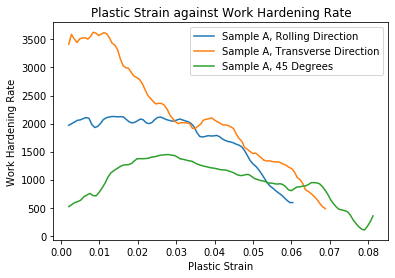

In [7]:
plot_whr(RD_A_Plastic[:,0],RD_A_Plastic[:,1],'Sample A, Rolling Direction')
plot_whr(TD_A_Plastic[:,0],TD_A_Plastic[:,1],'Sample A, Transverse Direction')
plot_whr(FFD_A_Plastic[:,0],FFD_A_Plastic[:,1],'Sample A, 45 Degrees')
plt.savefig('Sample_A_WHR_Instron.png')

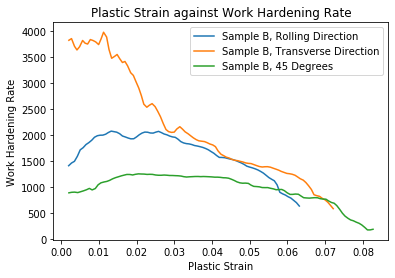

In [8]:
plot_whr(RD_B_Plastic[:,0],RD_B_Plastic[:,1],'Sample B, Rolling Direction')
plot_whr(TD_B_Plastic[:,0],TD_B_Plastic[:,1],'Sample B, Transverse Direction')
plot_whr(FFD_B_Plastic[:,0],FFD_B_Plastic[:,1],'Sample B, 45 Degrees')
plt.savefig('Sample_B_WHR_Instron.png')

### Using Considere's Criterion

In [9]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def plot_criterion(plastic,true,whrname,truename):
    fig, ax1 = plt.subplots()
    ax1.plot(plastic[:,1][::15],calc_reduced_whr(plastic[:,0],plastic[:,1]),'C0-',label=whrname)
    
    diff = np.shape(true[:,0])[0] - np.shape(plastic[:,1])[0]
    cropped_true = true[:,0][diff:]
    ax2 = ax1.twinx()
    ax2.plot(plastic[:,1],cropped_true,'C1-',label = truename)
    
    index = np.where(plastic[:,1][::15]>0.03)[0][0]
    intersect = np.where(cropped_true[::15][index:]>calc_reduced_whr(plastic[:,0],plastic[:,1])[index:])[0][0] + index
    ax2.plot(plastic[:,1][::15][intersect],cropped_true[::15][intersect],'ro')
    
    plt.title('Plotting Consideres Criterion')
    ax1.set_xlabel('Plastic Strain')
    ax1.set_ylabel('Work Hardening Rate')
    ax2.set_ylabel('True Stress (MPa)')
    
    if 'RD' in namestr(plastic, globals()):
        a,b = 0,2500
    if 'TD' in namestr(plastic, globals()):
        a,b = 0,4000
    if 'FFD' in namestr(plastic, globals()):
        a,b = 0,1500
    ax1.set_ylim(a,b)
    ax2.set_ylim(a,b)
    
    labels = ax1.plot(plastic[:,1][::15],calc_reduced_whr(plastic[:,0],plastic[:,1]),'C0-',label=whrname) + ax2.plot(plastic[:,1],cropped_true,'C1-',label = truename)
    labs = [l.get_label() for l in labels]
    ax1.legend(labels, labs, loc=0)

The above function is broken down into sections which do the following:
<br> 1) Plots plastic strain vs work hardening rate
<br> 2) Crops the true data to the same shape as the plastic data, then plots plastic strain vs true stress
<br> 3) Calculates the first index of the plastic strain array after which lines cross and plots this intersection as a red point on the graph. This is done for all values above 0.03 strain, as both samples in the 45 degree direction have two intersections on the work hardening graphs.
<br> 4) Plots a title and axis labels
<br> 5) Plots limits on the graph (dependant on the direction)
<br> 6) Plots all of the labels on the same legend

This can then be used to plot the point of intersection for each sample in all directions:

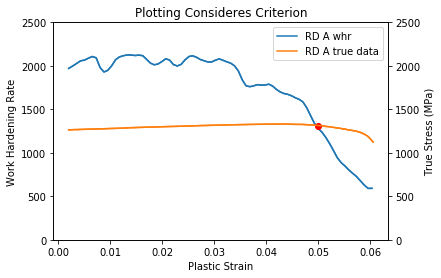

In [10]:
plot_criterion(RD_A_Plastic,RD_A_True,'RD A whr','RD A true data')
plt.savefig('RD_A_Consideres_Instron.png')
plt.show()

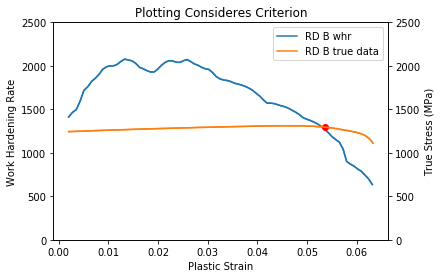

In [11]:
plot_criterion(RD_B_Plastic,RD_B_True,'RD B whr','RD B true data')
plt.savefig('RD_B_Consideres_Instron.png')
plt.show()

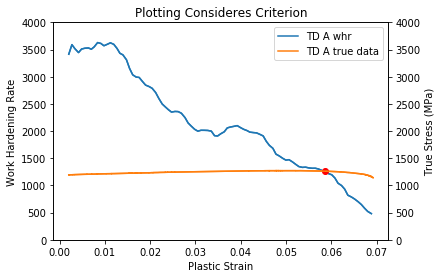

In [12]:
plot_criterion(TD_A_Plastic,TD_A_True,'TD A whr','TD A true data')
plt.savefig('TD_A_Consideres_Instron.png')
plt.show()

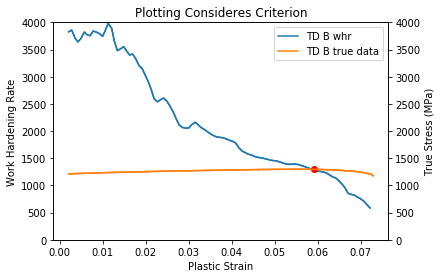

In [13]:
plot_criterion(TD_B_Plastic,TD_B_True,'TD B whr','TD B true data')
plt.savefig('TD_B_Consideres_Instron.png')
plt.show()

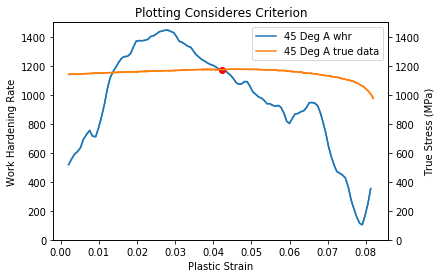

In [14]:
plot_criterion(FFD_A_Plastic,FFD_A_True,'45 Deg A whr','45 Deg A true data')
plt.savefig('45deg_A_Consideres_Instron.png')
plt.show()

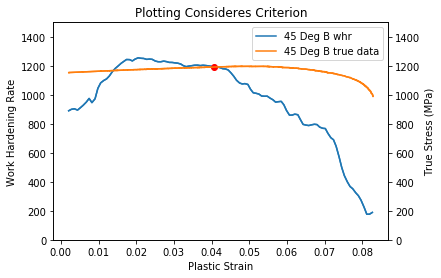

In [15]:
plot_criterion(FFD_B_Plastic,FFD_B_True,'45 Deg B whr','45 Deg B true data')
plt.savefig('45deg_B_Consideres_Instron.png')
plt.show()

### Finding the maximum value of the engineering data

On an engineering stress-strain curve, necking is considered to start at the UTS, which is given by the maximum point on the graph. Therefore, we can compare our strain values found using Considere's criterion for necking to the values at which the maximum of the stress/strain curves occur. Here a function is provided to find the strain value at which the maximum stress value occurs (for the engineering data), so it can later be compared to the value given by Considere's Criterion.

In [16]:
def find_eng_max(data):
    stress_max = np.max(data[:,0])
    index = np.where(data[:,0]==np.max(data[:,0]))[0][0]
    strain_val = data[:,1][index]
    print('Value of strain at which stress is maximum =',strain_val,'%')

### Plotting point of intersection against engineering stress-strain curves

In [17]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def engineering_check(plastic,true,engineering,m,name):
    diff = np.shape(true[:,0])[0] - np.shape(plastic[:,1])[0]
    cropped_true = true[:,0][diff:]
    index = np.where(plastic[:,1][::15]>0.03)[0][0]
    intersect = np.where(cropped_true[::15][index:]>calc_reduced_whr(plastic[:,0],plastic[:,1])[index:])[0][0] + index
    plas_strain_val = plastic[:,1][::15][intersect]
    stress_val = cropped_true[::15][intersect]
    
    true_strain_back = plas_strain_val + stress_val/m
    eng_strain_back = (np.exp(true_strain_back)-1)*100

    closest_val = find_nearest(engineering[:,1],eng_strain_back)
    closest_val_index = np.where(engineering[:,1]==closest_val)[0][0]

    plt.plot(engineering[:,1],engineering[:,0],'-',label=name)
    plt.plot(engineering[:,1][closest_val_index],engineering[:,0][closest_val_index],'ro')
    plt.xlabel('Engineering Strain (%)')
    plt.ylabel('Engineering Stress (MPa)')
    plt.legend(loc='best')
    plt.title('Engineering Stress-Strain with Consideres Point of Necking')
    print('Value of strain at which Consideres Criterion predicts necking to occur =', engineering[:,1][closest_val_index],'%')

Again, the above function is broken down into sections, which do the following:
<br> 1) Finds the values of plastic strain and  stress of the plotted intersects above
<br> 2) Converts plastic strain back to true strain, and then to engineering strain
<br> 3) Finds the index of nearest engineering strain value to this converted value of strain
<br> 4) Plots the engineering curve with the respective point, and prints the value of strain at which it occurs

Value of strain at which stress is maximum = 9.2842 %
Value of strain at which Consideres Criterion predicts necking to occur = 9.3506 %


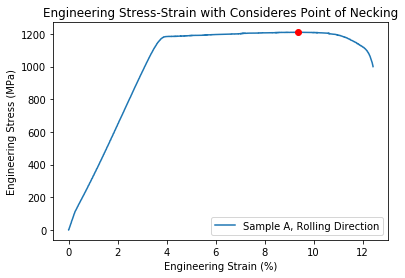

In [18]:
find_eng_max(RD_A)
engineering_check(RD_A_Plastic,RD_A_True,RD_A,RD_A_m,'Sample A, Rolling Direction')
plt.savefig('RD_A_Consideres_Point_Instron.png')

Value of strain at which stress is maximum = 9.9003 %
Value of strain at which Consideres Criterion predicts necking to occur = 9.9178 %


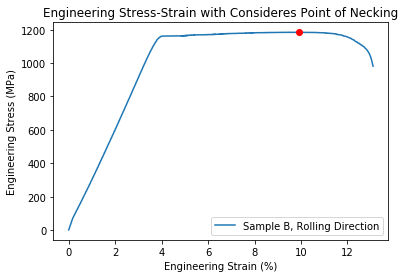

In [19]:
find_eng_max(RD_B)
engineering_check(RD_B_Plastic,RD_B_True,RD_B,RD_B_m,'Sample B, Rolling Direction')
plt.savefig('RD_B_Consideres_Point_Instron.png')

Value of strain at which stress is maximum = 9.88 %
Value of strain at which Consideres Criterion predicts necking to occur = 10.76 %


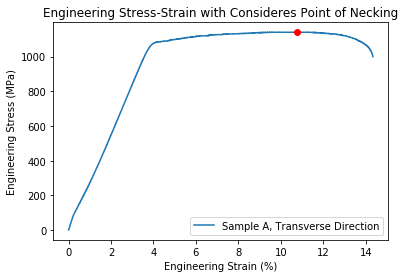

In [20]:
find_eng_max(TD_A)
engineering_check(TD_A_Plastic,TD_A_True,TD_A,TD_A_m,'Sample A, Transverse Direction')
plt.savefig('TD_A_Consideres_Point_Instron.png')

Value of strain at which stress is maximum = 10.17 %
Value of strain at which Consideres Criterion predicts necking to occur = 10.57 %


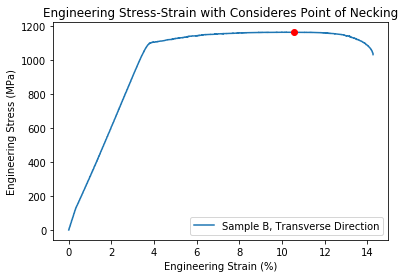

In [21]:
find_eng_max(TD_B)
engineering_check(TD_B_Plastic,TD_B_True,TD_B,TD_B_m,'Sample B, Transverse Direction')
plt.savefig('TD_B_Consideres_Point_Instron.png')

Value of strain at which stress is maximum = 3.83 %
Value of strain at which Consideres Criterion predicts necking to occur = 8.28 %


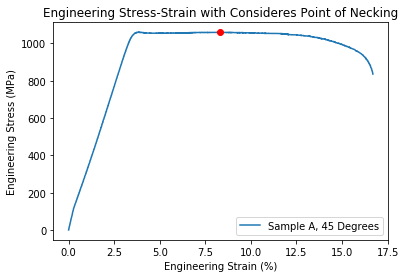

In [22]:
find_eng_max(FFD_A)
engineering_check(FFD_A_Plastic,FFD_A_True,FFD_A,FFD_A_m,'Sample A, 45 Degrees')
plt.savefig('45deg_A_Consideres_Point_Instron.png')

Value of strain at which stress is maximum = 3.83 %
Value of strain at which Consideres Criterion predicts necking to occur = 8.21 %


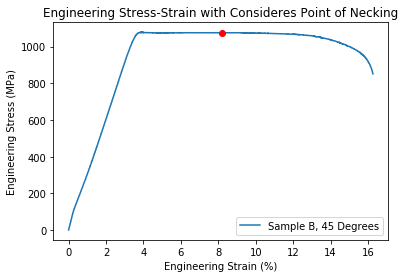

In [23]:
find_eng_max(FFD_A)
engineering_check(FFD_B_Plastic,FFD_B_True,FFD_B,FFD_B_m,'Sample B, 45 Degrees')
plt.savefig('45deg_B_Consideres_Point_Instron.png')

The compared values are very close for the rolling direction, somewhat close for the transverse direction and not close for 45 degrees. The reason for discrepancy in the values for the 45 degree direction is because the stress is highest here at yield, and decreases after this.

### Outputting these values into a table

In [24]:
def return_eng_max(data):
    stress_max = np.max(data[:,0])
    index = np.where(data[:,0]==np.max(data[:,0]))[0][0]
    return data[:,1][index]
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def return_consideres_val(plastic,true,engineering,m):
    diff = np.shape(true[:,0])[0] - np.shape(plastic[:,1])[0]
    cropped_true = true[:,0][diff:]
    index = np.where(plastic[:,1][::15]>0.03)[0][0]
    intersect = np.where(cropped_true[::15][index:]>calc_reduced_whr(plastic[:,0],plastic[:,1])[index:])[0][0] + index
    plas_strain_val = plastic[:,1][::15][intersect]
    stress_val = cropped_true[::15][intersect]
    true_strain_back = plas_strain_val + stress_val/m
    eng_strain_back = (np.exp(true_strain_back)-1)*100
    closest_val = find_nearest(engineering[:,1],eng_strain_back)
    closest_val_index = np.where(engineering[:,1]==closest_val)[0][0]
    return engineering[:,1][closest_val_index]

In [25]:
from IPython.display import HTML,display
import tabulate

list_1 = ['Sample A, Rolling Direction','Sample B, Rolling Direction','Sample A, Transverse Direction','Sample B, Transverse Direction','Sample A, 45 Degrees','Sample B, 45 Degrees']
list_2 = [return_consideres_val(RD_A_Plastic,RD_A_True,RD_A,RD_A_m),return_consideres_val(RD_B_Plastic,RD_B_True,RD_B,RD_B_m),return_consideres_val(TD_A_Plastic,TD_A_True,TD_A,TD_A_m),return_consideres_val(TD_B_Plastic,TD_B_True,TD_B,TD_B_m),return_consideres_val(FFD_A_Plastic,FFD_A_True,FFD_A,FFD_A_m),return_consideres_val(FFD_B_Plastic,FFD_B_True,FFD_B,FFD_B_m)]
list_3 = [return_eng_max(RD_A),return_eng_max(RD_B),return_eng_max(TD_A),return_eng_max(TD_B),return_eng_max(FFD_A),return_eng_max(FFD_B)]
                                                     
array = np.array((list_1,list_2,list_3))
table = array.T
headers= ['Sample','Consideres Strain Value for Necking (%)','Engineering Strain Value for Necking (%)']
display(HTML(tabulate.tabulate(table, headers = headers,tablefmt='html')))

Sample,Consideres Strain Value for Necking (%),Engineering Strain Value for Necking (%)
"Sample A, Rolling Direction",9.3506,9.2842
"Sample B, Rolling Direction",9.9178,9.9003
"Sample A, Transverse Direction",10.76,9.88
"Sample B, Transverse Direction",10.57,10.17
"Sample A, 45 Degrees",8.28,3.83
"Sample B, 45 Degrees",8.21,3.87
